In [4]:
import os
os.chdir(r"C:\Abdullah_Stock-Prices_Training_2")
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import ks_2samp
import pickle


In [5]:
# Load real and synthetic data
real = np.load("data/processed/stock_prices/test.npy")   # scaled
synth = np.load("outputs/synth/synth_data_2000w.npy")  # inverse-scaled

# Load scalers and rescale synthetic data back to scaled domain
scalers = pickle.load(open("data/processed/stock_prices/scalers.pkl", "rb"))

# Rescale each feature dimension separately
n, T, D = synth.shape
synth_scaled = np.zeros_like(synth)

for feature_idx in range(D):
    feature_data = synth[:, :, feature_idx].reshape(-1, 1)
    scaled_feature = scalers[feature_idx].transform(feature_data)
    synth_scaled[:, :, feature_idx] = scaled_feature.reshape(n, T)

print(f"Real data shape: {real.shape}")
print(f"Synth scaled shape: {synth_scaled.shape}")

Real data shape: (3382, 168, 5)
Synth scaled shape: (2000, 168, 5)


In [6]:
feat_names = open("data/processed/stock_prices/features.txt").read().splitlines()
f = 0  # feature index to inspect (0..6)


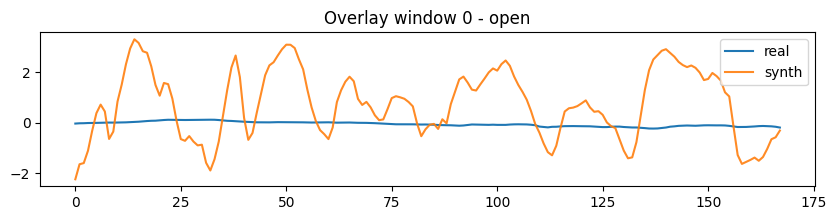

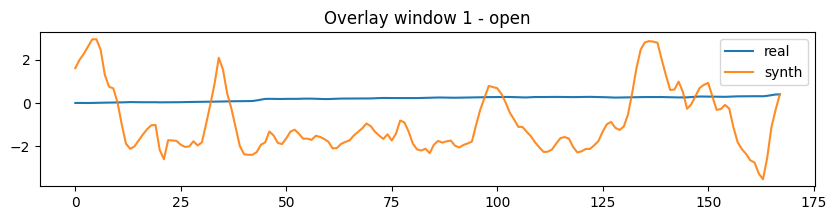

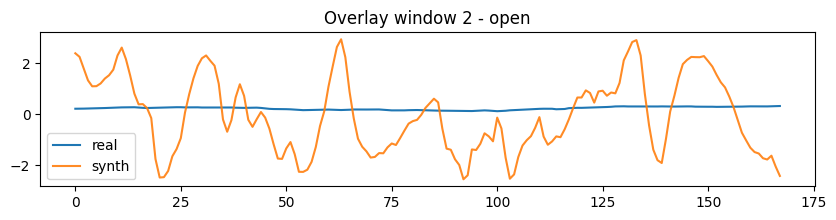

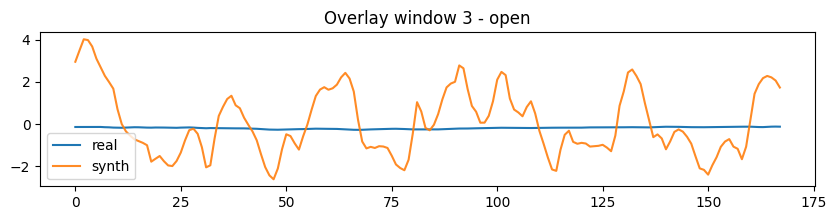

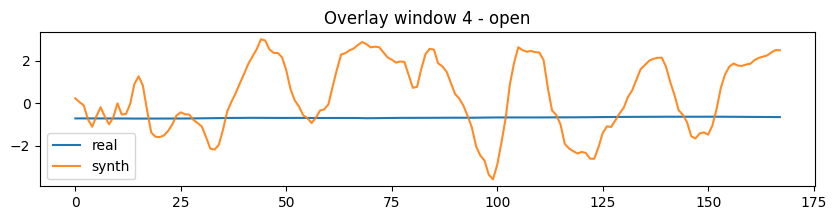

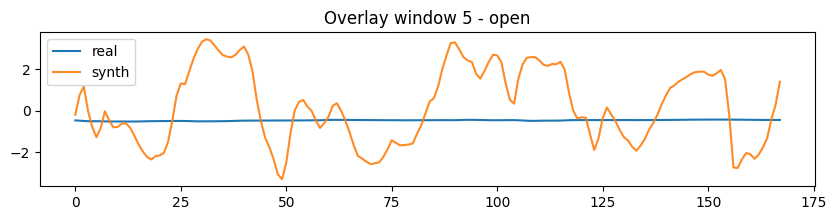

In [7]:
for i in range(6):
    plt.figure(figsize=(10, 2))
    plt.plot(real[i, :, f], label="real")
    plt.plot(synth_scaled[i, :, f], label="synth", alpha=0.9)
    plt.title(f"Overlay window {i} - {feat_names[f]}")
    plt.legend()
    plt.show()


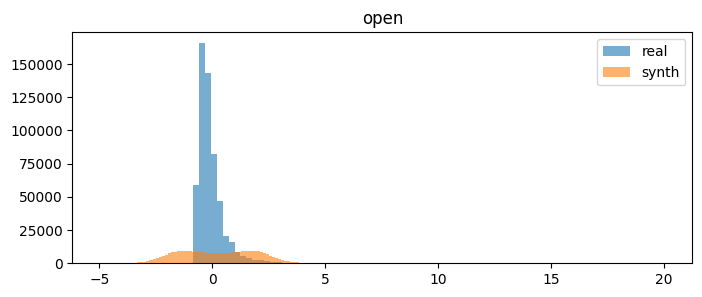

In [8]:
plt.figure(figsize=(8, 3))
plt.hist(real[:, :, f].ravel(), bins=80, alpha=0.6, label='real')
plt.hist(synth_scaled[:, :, f].ravel(), bins=80, alpha=0.6, label='synth')
plt.title(feat_names[f])
plt.legend()
plt.show()


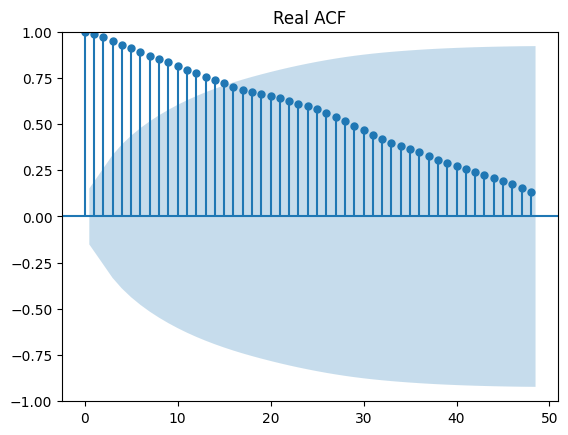

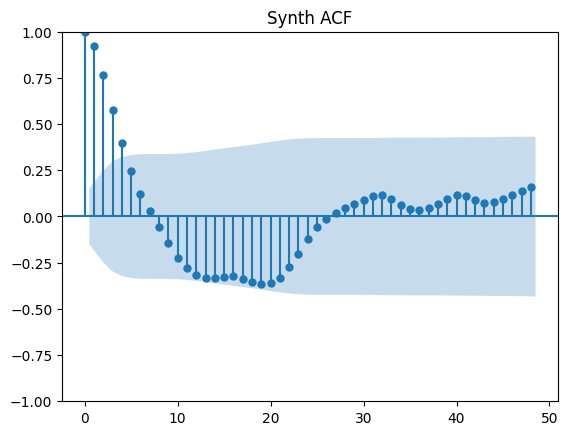

In [9]:
plot_acf(real[0, :, f], lags=48, title="Real ACF")
plt.show()

plot_acf(synth_scaled[0, :, f], lags=48, title="Synth ACF")
plt.show()


In [10]:
for fi, name in enumerate(feat_names):
    ks = ks_2samp(real[:, :, fi].ravel(), synth_scaled[:, :, fi].ravel())
    print(name, "KS stat:", ks.statistic, "pval:", ks.pvalue)


open KS stat: 0.33938066021796065 pval: 0.0
high KS stat: 0.4535137615809186 pval: 0.0
low KS stat: 0.35411691799724027 pval: 0.0
close KS stat: 0.40776135739629976 pval: 0.0
volume KS stat: 0.11075909929317673 pval: 0.0


In [11]:
import numpy as np
import pickle
from scipy.stats import ks_2samp
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from sklearn.linear_model import Ridge
import random

# reproducibility for sampling/shuffle
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [12]:
# load
real = np.load("data/processed/stock_prices/test.npy")   # scaled
synth_inv = np.load("outputs/synth/synth_data_2000w.npy")  # inverse-scaled

scalers = pickle.load(open("data/processed/stock_prices/scalers.pkl","rb"))
# rescale synth back to scaled space for direct comparison

n, T, D = synth_inv.shape
synth = np.zeros_like(synth_inv)

for feature_idx in range(D):
    feature_data = synth_inv[:, :, feature_idx].reshape(-1, 1)
    scaled_feature = scalers[feature_idx].transform(feature_data)
    synth[:, :, feature_idx] = scaled_feature.reshape(n, T)

feat_names = open("data/processed/stock_prices/features.txt").read().splitlines()

print("shapes -> real:", real.shape, "synth:", synth.shape)

shapes -> real: (3382, 168, 5) synth: (2000, 168, 5)


In [13]:
print("Feature | real_mean real_std | synth_mean synth_std | KS_stat KS_pval")
for i,name in enumerate(feat_names):
    r = real[:,:,i].ravel()
    s = synth[:,:,i].ravel()
    ks = ks_2samp(r, s)
    print(f"{name:20s} {r.mean():7.3f} {r.std():7.3f} | {s.mean():7.3f} {s.std():7.3f} | {ks.statistic:.3f} {ks.pvalue:.3e}")


Feature | real_mean real_std | synth_mean synth_std | KS_stat KS_pval
open                   0.001   1.019 |   0.249   1.655 | 0.339 0.000e+00
high                   0.001   1.018 |   0.662   1.240 | 0.454 0.000e+00
low                    0.001   1.020 |   0.342   1.148 | 0.354 0.000e+00
close                  0.001   1.019 |   0.519   1.113 | 0.408 0.000e+00
volume                -0.001   0.985 |   0.143   1.178 | 0.111 0.000e+00


In [14]:
def mmd_rbf_np(X, Y, sigma=None):
    """
    X, Y: arrays of shape (n_samples, seq_len, n_features) or similar
    returns: (mmd_value, sigma_used)
    """
    Xf = X.reshape(X.shape[0], -1)
    Yf = Y.reshape(Y.shape[0], -1)
    if sigma is None:
        # median heuristic on pairwise distances from X
        d = cdist(Xf, Xf, 'euclidean')
        med = np.median(d[d > 0]) if np.any(d > 0) else 1.0
        sigma = med if med > 0 else 1.0
    Kxx = np.exp(-cdist(Xf, Xf, 'sqeuclidean') / (2 * sigma * sigma))
    Kyy = np.exp(-cdist(Yf, Yf, 'sqeuclidean') / (2 * sigma * sigma))
    Kxy = np.exp(-cdist(Xf, Yf, 'sqeuclidean') / (2 * sigma * sigma))
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean(), sigma


In [15]:
# sample subset for speed (deterministic slice; you can randomize if desired)
n = min(200, real.shape[0], synth.shape[0])
r_samp = real[:n].copy()
s_samp = synth[:n].copy()

mmd_val, sigma = mmd_rbf_np(r_samp, s_samp)
print("MMD (real vs synth):", mmd_val, "sigma:", sigma)

# real vs permuted real baseline
perm = r_samp.copy()
np.random.shuffle(perm)   # in-place shuffle across samples
mmd_rr, _ = mmd_rbf_np(r_samp, perm, sigma=sigma)
print("MMD (real vs permuted-real):", mmd_rr)


MMD (real vs synth): 0.42005774166610943 sigma: 18.815452089419754
MMD (real vs permuted-real): 0.0


In [16]:
def avg_flat_dist(A, B, pairs=200):
    s = 0.0
    for _ in range(pairs):
        i = random.randrange(A.shape[0])
        j = random.randrange(B.shape[0])
        s += norm(A[i].ravel() - B[j].ravel())
    return s / pairs

print("Avg flat L2 dist (real, synth):", avg_flat_dist(r_samp, s_samp, pairs=200))
print("Avg flat L2 dist (real, real):", avg_flat_dist(r_samp, r_samp, pairs=200))


Avg flat L2 dist (real, synth): 45.802
Avg flat L2 dist (real, real): 26.642014


In [17]:
def prepare(X):
    # uses first half of sequence as features and mean of feature-0 in second half as target
    seq_len = X.shape[1]
    half = seq_len // 2
    X_flat = X[:, :half, :].reshape(X.shape[0], -1)
    y = X[:, half:, 0].mean(axis=1)
    return X_flat, y

# load training data for real
train = np.load("data/processed/stock_prices/train.npy")
Xr, Yr = prepare(train[:800])           # real-trained model uses train split
Xs, Ys = prepare(s_samp[:800])          # synth (sampled) used as pseudo-train
Xt, Yt = prepare(real[:200])            # test (from real)

m1 = Ridge().fit(Xr, Yr).score(Xt, Yt)
m2 = Ridge().fit(Xs, Ys).score(Xt, Yt)
print("R^2 (real-trained on test):", m1)
print("R^2 (synth-trained on test):", m2)


R^2 (real-trained on test): 0.9927505850791931
R^2 (synth-trained on test): -0.3472985029220581
